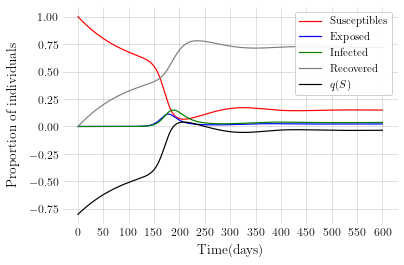

In [39]:
import numpy as np
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
import sys


matplotlib.rcParams['text.usetex'] = True
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

font = {'weight': 'normal', 'size': 12}  # Graph number's fontsize
plt.rc('font', **font)
plt.rc('legend', fontsize=11)  # Legend's fontsize


# Initial number of population
N0 = 7753000000

# Initial proportion of susceptible, exposed, infectious and vaccinated ind.
S0, E0, I0, R0 = (N0-1)/N0, 0/N0, 1/N0, 0/N0

# Demographic parameters 
A, mu = 0.005, 0.005

# Epidemiologic parameters 
alpha, beta, gamma, sigma = 0.01, 0.57, 0.067, 0.13

# Maximum and minimum vaccination proportions
qmax, qmin = 1.0, 0.1
k = qmax-qmin

# Time interval limits
t0, tmax = 0, 600
# A grid of time points (in days)
t = np.linspace(t0, tmax, 1000)

# -----------------------------------------------------------------------------
#                       Differential equations 
# -----------------------------------------------------------------------------
def deriv(y, t, A, mu, alpha, beta, gamma, sigma, k):
    """
    Implements the differential equations in which the SEIR model is based.
    
    Args: 
        y (tuple): tuple containing S, E, I and R variables
        t (Numpy.ndarray): grid of time points in [t0, tmax] interval
        A (float): proportion of new individuals per unit time
        mu (float): natural death rate
        alpha (float): disease-related death rate
        beta (float): contact rate
        gamma (float): recovery rate
        sigma (float): inverse latent period
        k (float): proportionality coefficient
        
    Returns:
        dSdt (float): derivative of S in time t
        dEdt (float): derivative of E in time t
        dIdt (float): derivative of I in time t
        dRdt (float): derivative of R in time t
    """    
    S, E, I, R = y
    dSdt = (1-(qmin+ k*S))*A - (beta*I+mu)*S 
    dEdt = beta*S*I - (mu+sigma)*E
    dIdt = sigma*E - (mu+gamma+alpha)*I
    dRdt = gamma*I - mu*R + (qmin+ k*S)*A    
    return dSdt, dEdt, dIdt, dRdt

def integrate(y0, t): 
    """
    Function that integrates the SEIR equations over the given time interval.
    
    Args: 
        y0 (tuple): tuple containing S, E, I and R variablesi initial values
        t (Numpy.ndarray): grid of time points in [t0, tmax] interval
    Returns:
        S (Numpy.ndarray): solution of S in [t0, tmax] interval
        E (Numpy.ndarray): solution of E in [t0, tmax] interval
        I (Numpy.ndarray): solution of I in [t0, tmax] interval
        R (Numpy.ndarray): solution of R in [t0, tmax] interval
        N (Numpy.ndarray): solution of N in [t0, tmax] interval
    """
    ret = odeint(deriv, y0, t, args=(A, mu, alpha, beta, gamma, sigma, k))
    S, E, I, R = ret.T
    N = S + E + I + R
    return [S, E, I, R, N]

# Initial conditions
y0 = S0, E0, I0, R0
# Integrate the SEIR equations over the time grid
[S, E, I, R, N] = integrate(y0, t)


fig = plt.figure(facecolor='w' )
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(t, S, 'red', lw=1.2, label='Susceptibles')
ax.plot(t, E, 'blue', lw=1.2, label='Exposed')
ax.plot(t, I, 'green', lw=1.2, label='Infected')  
ax.plot(t, R, 'grey', lw=1.2, label='Recovered')  
ax.plot(t, (qmin+k*S), 'black', lw=1.2, label='$q(S)$')  
 
ax.set_xlabel('Time(days)', fontsize=13.5, labelpad=6)
ax.set_ylabel('Proportion of individuals', fontsize=13.5, labelpad=10)

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.set_xticks([0,50,100,150,200,250,300,350,400,450,500,550,600])
ax.grid(b=True, which='major', c='silver', lw=0.5, ls='-')
legend = ax.legend(loc=1)
legend.get_frame().set_alpha(0.9)

for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.savefig('41control2.png', dpi=600)
plt.show()

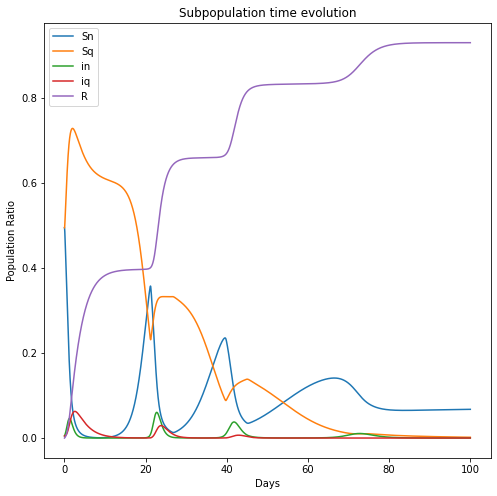

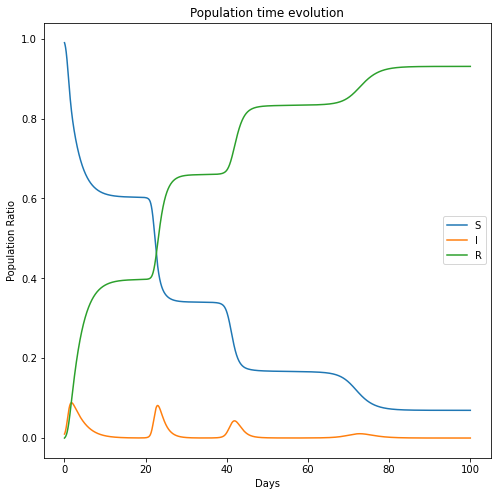

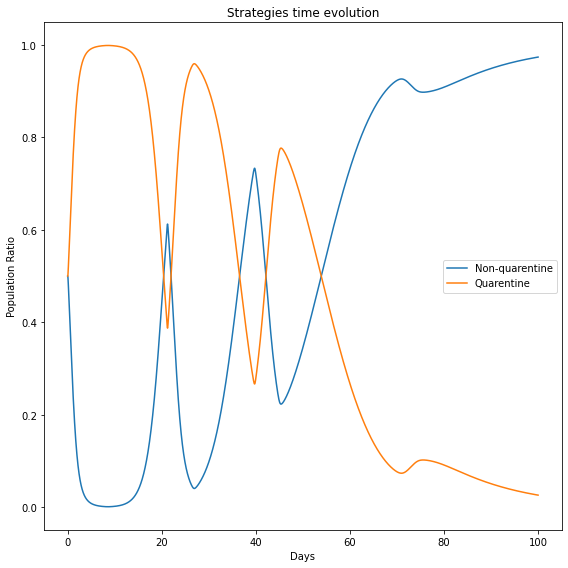

In [1]:
# Simplified program for obtaining the numerical integration of the Quarantine Game version of the SIR model
# This script was developed by Marco Antonio Amaral, as a suplemental material for the related research paper at:
# .... arxiv number
# For more information please contact the author at marcoantonio.amaral@gmail.com
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# SIR model with quarentine (Q) and carless (N) strategies
# Mean-field, well-mixed populations
# 5 compartments, Sq, Sn, Iq, In and R
# Parameters
quac = 1          			# quarentine cost
disec = 10        			# disease cost
betac = 1.0       			# infection rate for cooperators
betad = 10.0                 	 	# infection rate for defectors
betam = 0.1*(betac+betad)/2   	# cross infection rate
gamma = 1.0         			# recovery rate
tau = 1         			# strategy change time scale
k = 0.1           			# irrationality
tmax = 100         			# maximum time
h = 0.01          			# integration step
C0 = 0.5          			# initial fraction of C
D0 = 1-C0         			# initial fraction of D
S0 = 0.99         			# initial susceptibles
I0 = 1-S0         			# initial fraction of I
R0 = 0            			# initial fraction of R
t0 = 0.0          			# initial time


def model(y, t, quac, disec, betac, betad, betam, gamma, tau, k):
    # function that returns dy/dt
    sd = y[0]
    sc = y[1]
    id = y[2]
    ic = y[3]
    r = y[4]

    uc = -quac				             # cooperator's payoff
    ud = -(id+ic)*betad*disec		     # defector's payoff

    f_ucud = 1/(1+np.exp(-(ud-uc)/k))	 # fermi function
    f_uduc = 1/(1+np.exp(-(uc-ud)/k))	 # fermi function

    phisd = sc*sd*(f_ucud-f_uduc)
    phisd += sc*id*f_ucud-sd*ic*f_uduc  # Phi_S, susceptible, defector
    phiid = ic*id*(f_ucud-f_uduc)
    phiid += ic*sd*f_ucud-id*sc*f_uduc  # Phi_I, infected, defector

    sddot = -sd*(betad*id+betam*ic)+tau*phisd
    scdot = -sc*(betam*id+betac*ic)-tau*phisd
    iddot = sd*(betad*id+betam*ic)-gamma*id+tau*phiid
    icdot = sc*(betam*id+betac*ic)-gamma*ic-tau*phiid
    rdot = gamma*(id+ic)

    dfdt = [sddot, scdot, iddot, icdot, rdot]
    return dfdt


# Initialize values
sd0 = S0*D0
sc0 = S0*C0
id0 = I0*D0
ic0 = I0*C0
r0 = 0

# Bundle initial conditions for ODE solver
y0 = [sd0, sc0, id0, ic0, r0]

# Make time array for solution
tStop = tmax
tInc = h
t = np.arange(0., tStop, tInc)

# Call the ODE solver
psoln = odeint(model, y0, t, args=(quac, disec, betac, betad, betam, gamma, tau, k))

# Plot subpopulations as a function of time
fig1 = plt.figure(1, figsize=(8, 8))
plt.plot(t, psoln[:, 0], label='Sn')
plt.plot(t, psoln[:, 1], label='Sq')
plt.plot(t, psoln[:, 2], label='in')
plt.plot(t, psoln[:, 3], label='iq')
plt.plot(t, psoln[:, 4], label='R')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Population Ratio')
plt.title('Subpopulation time evolution')
plt.savefig('subpopulations.png')

# Plot populations as a function of time
fig2 = plt.figure(2, figsize=(8, 8))
plt.plot(t, psoln[:, 0]+psoln[:, 1], label='S')
plt.plot(t, psoln[:, 2]+psoln[:, 3], label='I')
plt.plot(t, psoln[:, 4], label='R')
plt.xlabel('Days')
plt.ylabel('Population Ratio')
plt.title('Population time evolution')
plt.legend()
plt.savefig('SIR.png')

fig3 = plt.figure(3, figsize=(8, 8))
# Plot strategies as a function of time
plt.plot(t, (psoln[:, 0]+psoln[:, 2])/(psoln[:, 0]+psoln[:, 2]+psoln[:, 1]+psoln[:, 3]), label='Non-quarentine')
plt.plot(t, (psoln[:, 1]+psoln[:, 3])/(psoln[:, 0]+psoln[:, 2]+psoln[:, 1]+psoln[:, 3]), label='Quarentine')
plt.xlabel('Days')
plt.ylabel('Population Ratio')
plt.title('Strategies time evolution')
plt.legend()
plt.savefig('Quarentinevsnonquarentine.png')

plt.tight_layout()
plt.show()

In [26]:
psoln[:, 2]

array([5.00000000e-03, 5.21364591e-03, 5.43226054e-03, ...,
       2.31091773e-06, 2.30346644e-06, 2.29603746e-06])

Infectious prop: -3.936327168753386e-43


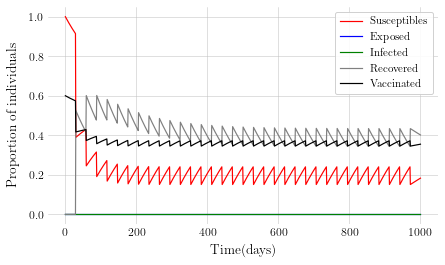

In [19]:
import numpy as np
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
import sys



matplotlib.rcParams['text.usetex'] = True
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

font = {'weight': 'normal', 'size': 12}  # Graph number's fontsize
plt.rc('font', **font)
plt.rc('legend', fontsize=11)  # Legend's fontsize

# Initial number of population
N0 = 7753000000

# Initial proportion of susceptible, exposed, infectious and vaccinated ind.
S0, E0, I0, R0 = (N0-1)/N0, 0/N0, 1/N0, 0/N0

# Demographic parameters 
A, mu = 0.0045, 0.0077

# Epidemiologic parameters 
alpha, beta, gamma, sigma = 0.09, 0.13, 0.125, 0.166

# Maximum and minimum vaccination proportions
pmax, pmin = 0.60, 0.30
k = pmax - pmin

# Pulse vaccination period 
T = 30

# Time interval limits
t0, tmax = 0, 1000
# Time subintervals' step number
ss = 30


def deriv(y, t, A, alpha, beta, gamma, mu, sigma):
    """
    Implements the differential equations in which the SEIR model is based.
    
    Args: 
        y (tuple): tuple containing S, E, I and R variables
        t (Numpy.ndarray): grid of time points in [t0, tmax] interval
        A (float): proportion of new individuals per unit time
        mu (float): natural death rate
        alpha (float): disease-related death rate
        beta (float): contact rate
        gamma (float): recovery rate
        sigma (float): inverse latent period
        
    Returns:
        dSdt (float): derivative of S in time t
        dEdt (float): derivative of E in time t
        dIdt (float): derivative of I in time t
        dRdt (float): derivative of R in time t
    """
    S, E, I, R = y
    dSdt = A - (beta*I+mu)*S 
    dEdt = beta*S*I - (mu+sigma)*E
    dIdt = sigma*E - (mu+gamma+alpha)*I
    dRdt = gamma*I - mu*R   
    return dSdt, dEdt, dIdt, dRdt

def integrate(y0, t): 
    """
    Function that integrates the SEIR equations over the given time interval.
    
    Args: 
        y0 (tuple): tuple containing S, E, I and R variablesi initial values
        t (Numpy.ndarray): grid of time points in [t0, tmax] interval
    Returns:
        S (Numpy.ndarray): solution of S in [t0, tmax] interval
        E (Numpy.ndarray): solution of E in [t0, tmax] interval
        I (Numpy.ndarray): solution of I in [t0, tmax] interval
        R (Numpy.ndarray): solution of R in [t0, tmax] interval
        N (Numpy.ndarray): solution of N in [t0, tmax] interval
    """ 
    ret = odeint(deriv, y0, t, args=( A, alpha, beta, gamma, mu, sigma))
    S, E, I, R = ret.T
    N = S + E + I + R
    return [S, E, I, R, N]



# First time interval 
y0 = S0, E0, I0, R0
t = np.linspace(t0, T, ss)
[S, E, I, R, N] = integrate(y0, t)

# Time interval number: IT MUST BE BIGGER THAN OR EQUAL TO 1
nf  = (tmax-t0)/T 
n = int(np.floor(nf))

# Middle time intervals
for i in range(1,n):
    
    length = len(N)
    S0 = (1-(pmin+ k*S[length-1]))*S[length-1]
    R0 = R[length-1] + (pmin+ k*S[length-1])*S[length-1]    
    y0 = S0, E[length-1], I[length-1], R0
    t = np.linspace(i*T, (i+1)*T, ss)
        
    [subS, subE, subI, subR, subN] = integrate(y0, t)
        
    S = np.append(S, subS)
    E = np.append(E, subE)
    I = np.append(I, subI)
    R = np.append(R, subR)
    N = np.append(N, subN)

# Last time interval
if nf!=n:
    
    S0 = (1-(pmin+ k*S[length+ss-1]))*S[length+ss-1]
    R0 = R[length+ss-1] + (pmin+ k*S[length+ss-1])*S[length+ss-1]
    y0 = S0, E[length+ss-1], I[length+ss-1], R0
    t = np.linspace(n*T, tmax, ss)
    
    [subS, subE, subI, subR, subN] = integrate(y0, t)

    S = np.append(S, subS)
    E = np.append(E, subE)
    I = np.append(I, subI)
    R = np.append(R, subR)
    N = np.append(N, subN)   
    
# Whole time interval (for future plots)
length = len(N)
t = np.linspace(t0, tmax, length)
print("Infectious prop:" , I[len(I)-1])

# -----------------------------------------------------------------------------
#                            Plot the data
# -----------------------------------------------------------------------------

fig = plt.figure(facecolor='w',figsize=(7,4))
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(t, S, 'red', lw=1.2, label='Susceptibles')
ax.plot(t, E, 'blue', lw=1.2, label='Exposed')
ax.plot(t, I, 'green', lw=1.2, label='Infected')  
ax.plot(t, R, 'grey', lw=1.2, label='Recovered')  
ax.plot(t, (pmin+k*S), 'black', lw=1.2, label='Vaccinated')  

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))     
ax.set_xlabel('Time(days)', fontsize=13.5, labelpad=6)
ax.set_ylabel('Proportion of individuals', fontsize=13.5, labelpad=10)

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='silver', lw=0.5, ls='-')
legend = ax.legend(loc=1)
legend.get_frame().set_alpha(0.9)

for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.savefig('prueba.png', dpi=600)
plt.show()